In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau
import itertools

In [ ]:
# Define the dataset path
dataset_path = '/content/drive/MyDrive/Training'

In [ ]:
# Get the list of categories
categories = ['0Normal', '1Doubtful', '2Mild', '3Moderate', '4Severe']
data = []

In [ ]:
import os

# Path to the dataset in Google Drive
dataset_path = '/content/drive/MyDrive/Training'

# Verify the folder's contents
print(os.listdir(dataset_path))

['2Mild', '3Moderate', '1Doubtful', '0Normal', '4Severe']


In [ ]:
# Collect data information
for category in categories:
    category_path = os.path.join(dataset_path, category)
    for filename in os.listdir(category_path):
        data.append((category, filename))

In [ ]:
# Create a DataFrame
df = pd.DataFrame(data, columns=['Category', 'Filename'])
print(df.head())
print(df['Category'].value_counts())

  Category            Filename
0  0Normal  NormalG0 (133).png
1  0Normal  NormalG0 (175).png
2  0Normal  NormalG0 (300).png
3  0Normal   NormalG0 (19).png
4  0Normal  NormalG0 (212).png
Category
0Normal      514
1Doubtful    477
2Mild        232
3Moderate    221
4Severe      206
Name: count, dtype: int64


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
df['Encoded_Category'] = label_encoder.fit_transform(df['Category'])

In [ ]:
# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Encoded_Category'])

print(train_df.shape, test_df.shape)

(1320, 3) (330, 3)


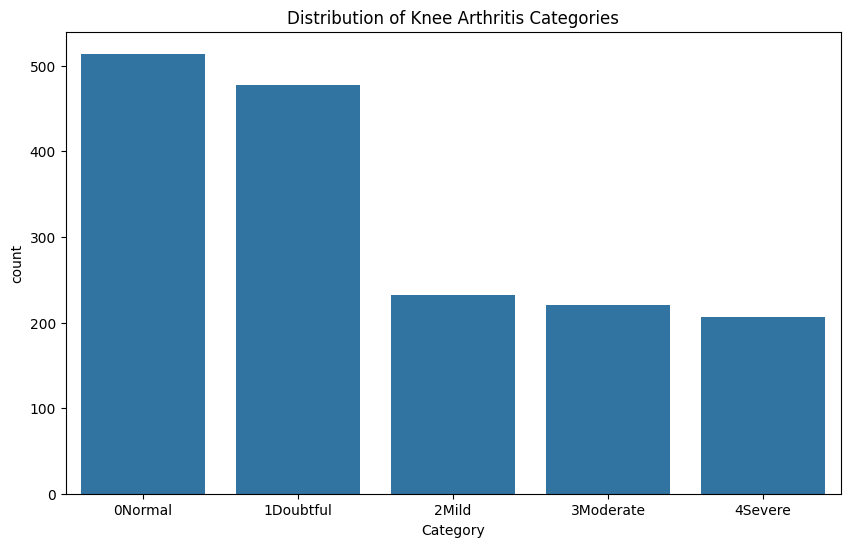

In [ ]:
# Plot the distribution of categories
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Category')
plt.title('Distribution of Knee Arthritis Categories')
plt.show()

In [ ]:
# Function to load and preprocess image
def load_and_preprocess_image(filepath):
    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert to RGB
    image = cv2.resize(image, (224, 224))  # Resize to a fixed size
    image = preprocess_input(image)  # Preprocess input for EfficientNetB0
    return image

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Prepare the data for training
def prepare_data(df, dataset_path):
    images = []
    labels = []
    for _, row in df.iterrows():
        filepath = os.path.join(dataset_path, row['Category'], row['Filename'])
        image = load_and_preprocess_image(filepath)
        images.append(image)
        labels.append(row['Encoded_Category'])
    return np.array(images), np.array(labels)

train_images, train_labels = prepare_data(train_df, dataset_path)
test_images, test_labels = prepare_data(test_df, dataset_path)

In [ ]:
# Augment the training data
train_augmented_flow = datagen.flow(train_images, train_labels, batch_size=len(train_images), shuffle=False)
train_images_augmented, train_labels_augmented = next(train_augmented_flow)

In [ ]:
# Concatenate the original and augmented data
train_images_augmented = np.concatenate([train_images, train_images_augmented])
train_labels_augmented = np.concatenate([train_labels, train_labels_augmented])

In [ ]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Unfreeze some layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

In [ ]:
# Add new top layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Add learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

In [ ]:
# Train the model
history = model.fit(train_images_augmented, train_labels_augmented, epochs=30, validation_data=(test_images, test_labels), callbacks=[lr_scheduler])

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 601s 7s/step - accuracy: 0.4529 - loss: 1.3900 - val_accuracy: 0.3121 - val_loss: 11.6076 - learning_rate: 0.0010
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 621s 7s/step - accuracy: 0.6814 - loss: 0.8050 - val_accuracy: 0.3121 - val_loss: 16.2644 - learning_rate: 0.0010
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 595s 6s/step - accuracy: 0.7610 - loss: 0.6404 - val_accuracy: 0.3061 - val_loss: 15.0482 - learning_rate: 0.0010
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 569s 7s/step - accuracy: 0.7451 - loss: 0.6302 - val_accuracy: 0.3121 - val_loss: 25.2493 - learning_rate: 0.0010
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 567s 7s/step - accuracy: 0.7964 - loss: 0.5235 - val_accuracy: 0.3273 - val_loss: 13.9220 - learning_rate: 0.0010
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8423 - loss: 0.4138
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
83/83 ━━━━━━━━━━━━━━━━━━━━ 545s 6s/step - accuracy: 0.8422 - loss: 0.4142 - val_a

KeyboardInterrupt: 

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'Test accuracy: {test_acc}')

In [ ]:
# Generate predictions
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
# Print classification report
print(classification_report(test_labels, predicted_classes, target_names=label_encoder.classes_))

In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Compute confusion matrix
cm = confusion_matrix(test_labels, predicted_classes)
plot_confusion_matrix(cm, classes=label_encoder.classes_)